In [163]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import ast
from func import * 
import math
%matplotlib inline
import numpy as np
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [240]:
df = pd.read_csv("merged_df.csv")

In [241]:
df.drop(columns=['bbox_id','keypoints','area'], inplace=True)
df["image_id"] = df["image_id"].astype(str).apply(lambda x: x.rjust(12, '0') + ".jpg")
df['bbox'] = df['bbox'].apply(ast.literal_eval)
df['image_file'] = str('val2017/')+df['image_id']
df.drop(columns='image_id', inplace=True)

In [242]:
def img_metric(img_path):
    # bbox 하나만 가져오기
    bbox = df[df['image_file']== img_path]['bbox'].iloc[0]

    # bbox 정보에서 x, y, w, h 추출
    x, y, w, h = map(int, bbox)

    # 이미지를 bbox에 맞게 자르기
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    cropped_image = image[y:y+h, x:x+w]
    c_moment_value = moment(cropped_image)
    return c_moment_value, cropped_image

In [243]:
c_moment_value, cropped_image = img_metric('val2017/000000003934.jpg')
c_moment_value

(14, 55)

In [244]:
def visualize_points(img_path):
    c_moment_value, cropped_image = img_metric(img_path)
    print(c_moment_value)
    x, y = map(int, c_moment_value)

    # # OpenCV 창에서 이미지 보기
    # cv2.imshow('Image with Points', cropped_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    # Matplotlib을 사용하여 이미지 보기
    plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    plt.scatter(x, y, color='red', s=30)  # 빨간색으로 점 찍기
    plt.axis(False)
    plt.show()

(14, 55)


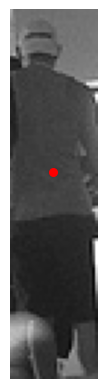

In [245]:
# crop된 이미지(bbox)에서 centroid moment좌표
visualize_points('val2017/000000003934.jpg')

In [246]:
img.shape

(512, 640, 3)

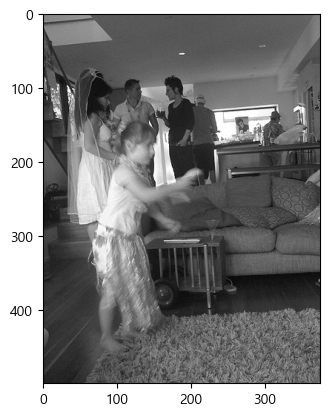

In [247]:
# original image
img = cv2.imread('val2017/000000003934.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [248]:
# centroid moment와 이미지 중심좌표가 어느정도 떨어져 있는지에 대한 정도 
def centroid_degree(w, h, cx, cy):

    # 이미지 중심 좌표 계산
    center_x = w // 2
    center_y = h // 2

    l = math.sqrt(((center_x-cx)/w)**2+((center_y-cy)/h)**2)
    
    return l

In [249]:
centroid_l = []

for i in range(len(df)):
    bbox = df.loc[i,'bbox']
    
    # bbox 정보에서 x, y, w, h 추출
    x, y, w, h = map(int, bbox)

    # 이미지 로드
    image_file_path = df.loc[i,'image_file']
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)

    height, width= image.shape
    img_size_value = width * height

    # 이미지를 bbox에 맞게 자르기
    cropped_image = image[y:y+h, x:x+w]
    cx, cy = moment(cropped_image)
    centroid_l_value = centroid_degree(w, h, cx, cy)


    centroid_l.append(centroid_l_value)

In [250]:
df['centroid_l'] = centroid_l

In [251]:
sorted_df = df.sort_values(by='score', ascending=False, ignore_index=True)

In [252]:
high_score = sorted_df[sorted_df['score']>0.85]
low_score = sorted_df[sorted_df['score']<0.6]

<Axes: title={'center': 'centroid moment와 거리 중심 떨어져 있는 정도 (전체 bbox 이미지 score 정렬 )'}>

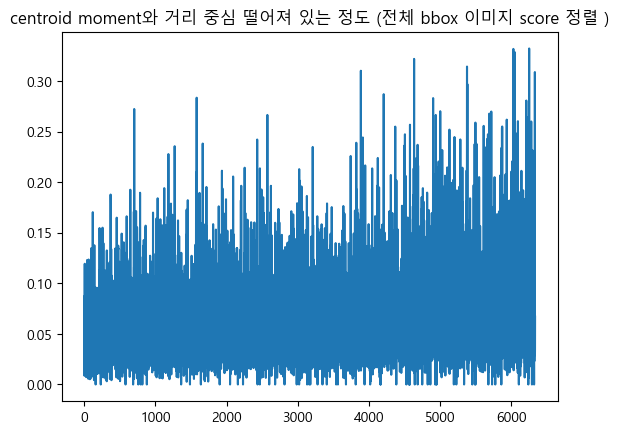

In [253]:
plt.title("centroid moment와 거리 중심 떨어져 있는 정도 (전체 bbox 이미지 score 정렬 )")
sorted_df['centroid_l'].plot()

<Axes: title={'center': 'low score centroid_l'}>

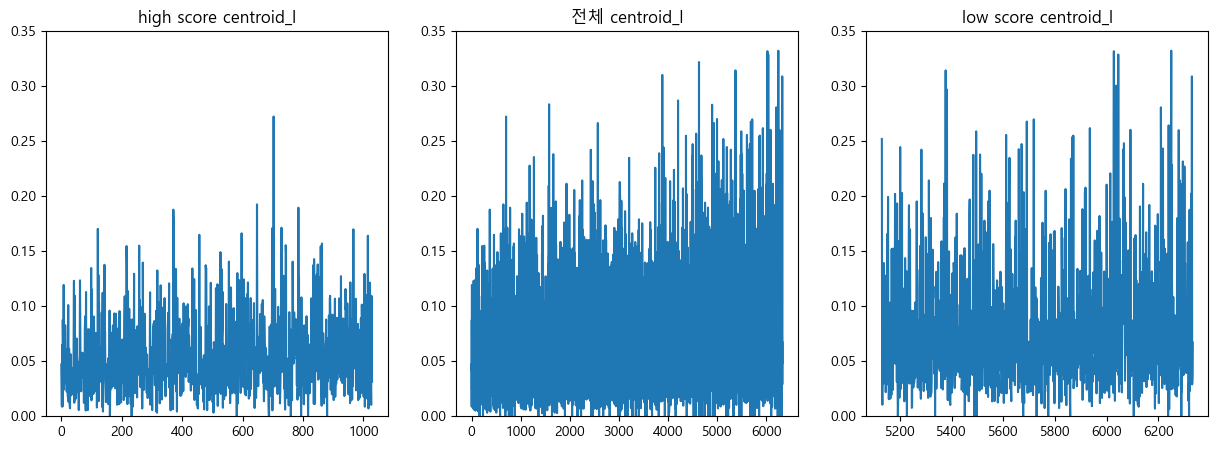

In [254]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score centroid_l")
plt.ylim(0,0.35)
high_score['centroid_l'].plot()

plt.subplot(1,3,2)
plt.title("전체 centroid_l")
plt.ylim(0,0.35)
sorted_df['centroid_l'].plot()

plt.subplot(1,3,3)
plt.title("low score centroid_l")
plt.ylim(0,0.35)
low_score['centroid_l'].plot()

In [255]:
high_score['centroid_l'].describe()

count    1030.000000
mean        0.054598
std         0.034910
min         0.000000
25%         0.028277
50%         0.047070
75%         0.073877
max         0.272490
Name: centroid_l, dtype: float64

In [186]:
sorted_df['centroid_l'].describe()

count    6334.000000
mean        0.067895
std         0.044793
min         0.000000
25%         0.035701
50%         0.058824
75%         0.088967
max         0.332341
Name: centroid_l, dtype: float64

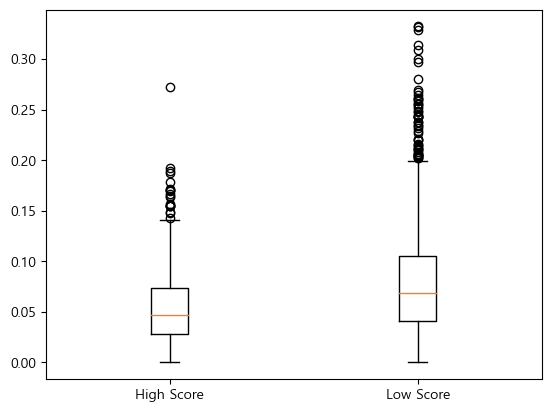

In [181]:
plt.boxplot([high_score['centroid_l'], low_score['centroid_l']], labels=['High Score', 'Low Score'])
plt.show()

In [ ]:
# c_moment_y 확인
tmp = pd.read_csv("df_0103.csv")
plt.title("centroid moment y 좌표 ")
tmp['c_moment_y'].plot()

<Axes: title={'center': 'low score c_moment_y'}>

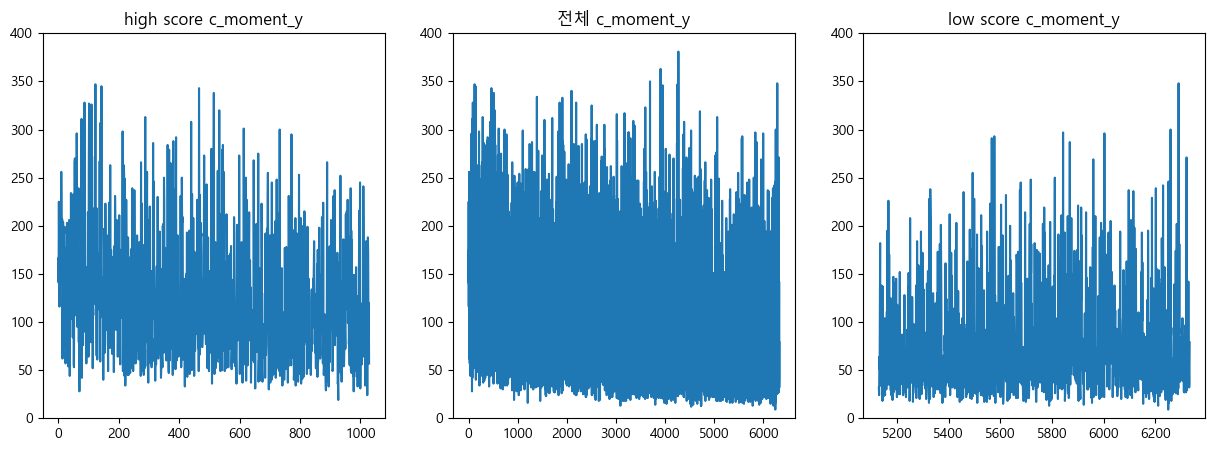

In [209]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score c_moment_y")
plt.ylim(0,400)
high_score['c_moment_y'].plot()

plt.subplot(1,3,2)
plt.title("전체 c_moment_y")
plt.ylim(0,400)
tmp['c_moment_y'].plot()

plt.subplot(1,3,3)
plt.title("low score c_moment_y")
plt.ylim(0,400)
low_score['c_moment_y'].plot()

c_moment_y값 : high_score > low_score
즉 low score에서는 centroid moment의 y좌표가 낮은 곳에 위치
-> bbox 크기가 고려되지 않은 단순 y좌표값

따라서 low score에서 centroid moment y값이 낮게 나올 수 있는 경우
1) 질량중심이 bbox 내부의 하단에 있는 경우 
2) bbox 이미지 자체가 작아 y값이 작게 나온 경우
대부분 경우 2)에 속할 것으로 예상.

유의미한 질량중심에 대한 좌표를 사용하기 위해서는 bbox 크기를 고려한 모멘트 계산 필요.

------------

### haralick관련 메트릭 확인하기

In [ ]:
tmp = pd.read_csv("df_0103.csv")

<Axes: title={'center': 'haralick Contrast (score로 descending)'}>

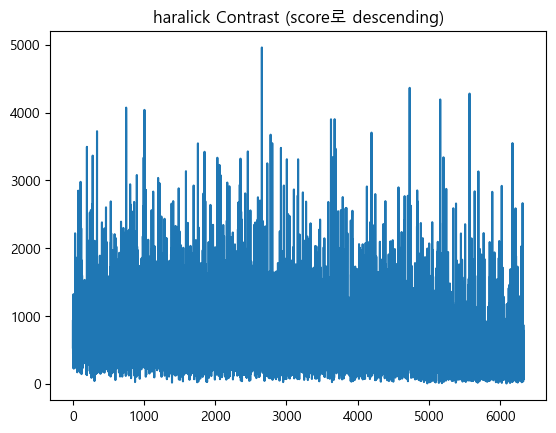

In [197]:
plt.title("haralick Contrast (score로 descending)")
tmp['Contrast'].plot()

In [198]:
tmp_high_score = tmp[tmp['score']>0.85]
tmp_low_score = tmp[tmp['score']<0.6]

<Axes: title={'center': 'low score Contrast'}>

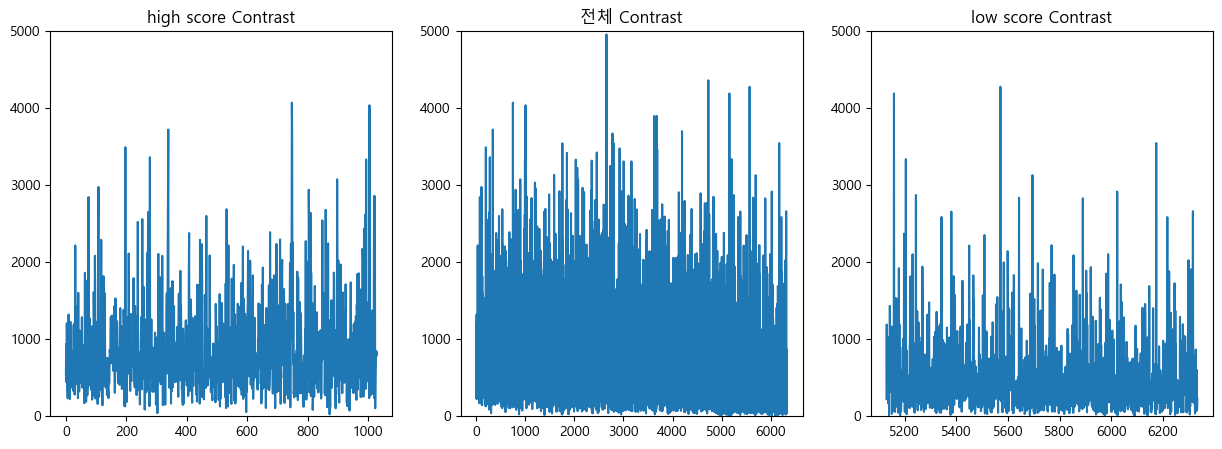

In [204]:
fig = plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.title("high score Contrast")
plt.ylim(0,5000)
tmp_high_score['Contrast'].plot()

plt.subplot(1,3,2)
plt.title("전체 Contrast")
plt.ylim(0,5000)
tmp['Contrast'].plot()

plt.subplot(1,3,3)
plt.title("low score Contrast")
plt.ylim(0,5000)
tmp_low_score['Contrast'].plot()

In [207]:
tmp['Contrast'].describe()

count    6334.000000
mean      729.976534
std       585.421957
min         4.502463
25%       300.976368
50%       577.569410
75%       995.263899
max      4958.811655
Name: Contrast, dtype: float64

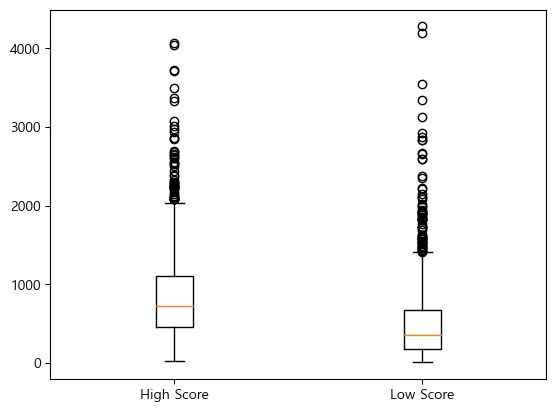

In [208]:
plt.boxplot([tmp_high_score['Contrast'], tmp_low_score['Contrast']], labels=['High Score', 'Low Score'])
plt.show()

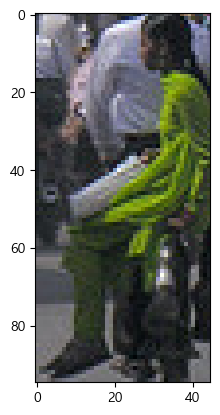

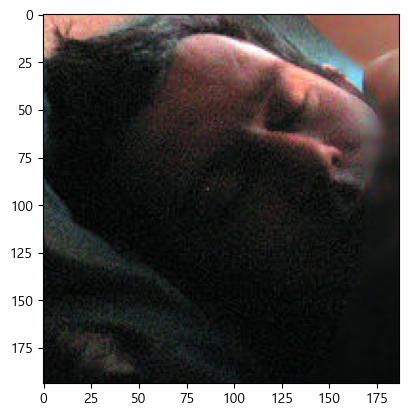

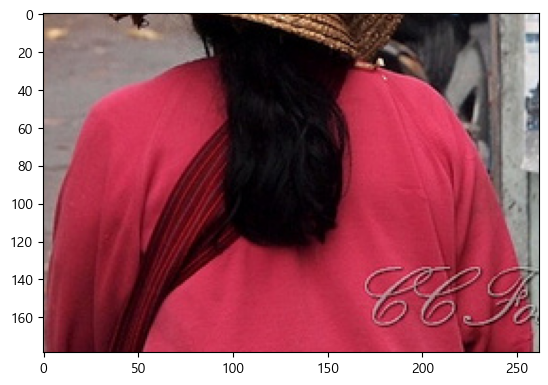

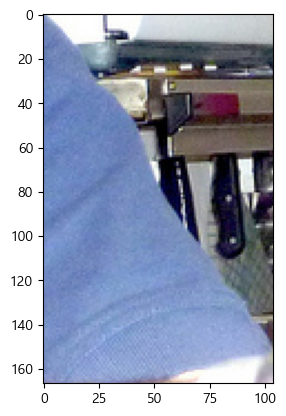

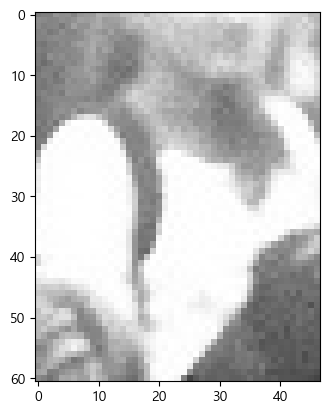

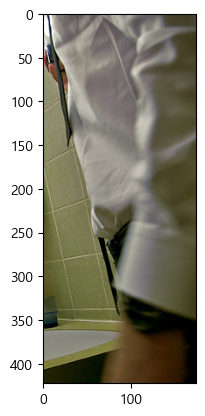

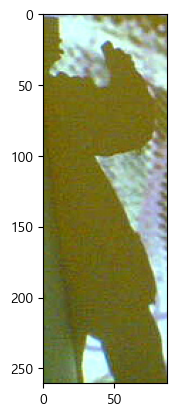

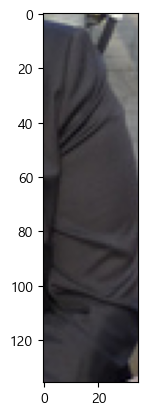

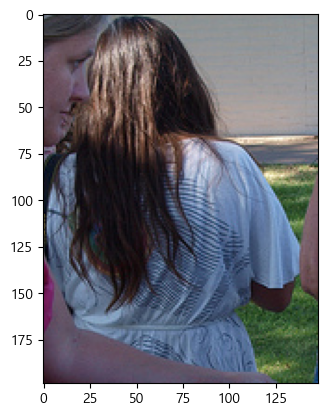

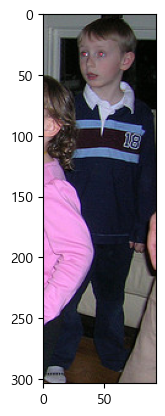

In [266]:
# low score image, high score image 살펴보기
import random

score_df = low_score # option : low_score/ high_score/ sorted_df

for _ in range(10):
    img_num = random.randrange(len(score_df))
    img_path = score_df.iloc[img_num].image_file
    bbox = score_df.iloc[img_num].bbox
    x, y, w, h = map(int, bbox)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_image = img[y:y+h, x:x+w]
    plt.imshow(cropped_image)
    plt.show()